In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import numpy as np
import warnings

## Obtener datos

In [2]:
tipos_de_ingresos_files_xls = [
    "data/input/ingresos/alcaldia_tipo_de_ingresos.xlsx",
    "data/input/ingresos/gobernacion_tipo_de_ingresos.xlsx",
]


ingresos_df = pd.DataFrame()

## Concatenar los dos archivos
for f in tipos_de_ingresos_files_xls:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df_temp = pd.read_excel(f, engine="openpyxl")

    ingresos_df = pd.concat([ingresos_df, df_temp], ignore_index=True)
    

## Renombrar las columnas
ingresos_df = ingresos_df.rename(
    columns={
        "Corporaciones - ID Corporacion → Nombre": "Cargo",
        "Formato Ingresos Gastos - ID Formato Ingresos Gasto → Codigo": "Gasto Id",
        "Candidatos → Sexo": "Sexo",
        "Candidatos → Etnia": "Etnia",
        "Departamentos - ID Departamento → Nombre": "Departamento",
        "Ciudades → Nombre": "Ciudades",
        "Agrupaciones Politicas → Nombre": "Agrupacion Politica",
        "Coalicion Politica → Nombre": "Coalicion Politica",
        "Grupos Significativos → Nombre": "Grupo Politico",
        "Suma de Ingresos → Total": "Total",
        "Codigo pro":"Codigo Pro"
    }
)
    
ingresos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8712 entries, 0 to 8711
Data columns (total 18 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Nombre                                                        8712 non-null   object 
 1   Apellido                                                      8712 non-null   object 
 2   Cargo                                                         8712 non-null   object 
 3   Gasto Id                                                      8712 non-null   int64  
 4   Sexo                                                          8710 non-null   object 
 5   Etnia                                                         4281 non-null   float64
 6   Departamento                                                  8712 non-null   object 
 7   Ciudades                                                      8235 no

### Convertir tres columnas con valores únicos a dos columnas con tipo y valor

In [3]:
columnas_originales = [
    "Agrupacion Politica",
    "Coalicion Politica",
    "Grupo Politico",
]


def categorizar(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]
    if isinstance(aggPolitica, str):
        return "Agrupacion Politica"
    if isinstance(coalicionPolitica, str):
        return "Coalicion Politica"
    if isinstance(grupoPolitico, str):
        return "Grupo Politico"


def categorizarConNombre(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]

    if isinstance(aggPolitica, str):
        return aggPolitica
    if isinstance(coalicionPolitica, str):
        return coalicionPolitica
    if isinstance(grupoPolitico, str):
        return grupoPolitico


ingresos_df["Tipo de Agrupación"] = ingresos_df.apply(categorizar, axis=1)
ingresos_df["Nombre de Agrupación"] = ingresos_df.apply(categorizarConNombre, axis=1)

ingresos_df = ingresos_df.drop(columns=columnas_originales)


def millions_billions_formatter(x,pos):
    if x >= 1e9:
        return f"{x / 1e9:.0f}B"
    elif x >= 1e6:
        return f"{x / 1e6:.0f}M"
    else:
        return f"{x:.0f}"


def autoLabel():
    for bar in plt.gca().patches:
        height = bar.get_height()

        formatted_height = millions_billions_formatter(height,None)
        plt.gca().annotate(
            formatted_height,
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # Desplazamiento vertical del texto
            textcoords="offset points",
            ha="center",
            va="bottom",
        )


ingresos_df.head()  ##Mostrar las primeras filas

,Nombre,Apellido,Cargo,Gasto Id,Sexo,Etnia,Departamento,Ciudades,Total,Contar,Etnias,Género,Codigo Pro,Formato Ingresos Gastos - ID Formato Ingresos Gasto → Nombre,Tipos Circunscripcion - ID Circunscripcion → Nombre,Tipo de Agrupación,Nombre de Agrupación
0,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,101,M,NaN,Antioquia,San Rafael,29000000.0,3,NaN,Masculino,101 - Recursos propios y familiares,NaN,NaN,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
1,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,102,M,NaN,Antioquia,San Rafael,100000.0,1,NaN,Masculino,102 - Donaciones de particulares,NaN,NaN,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
2,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,106,M,NaN,Antioquia,San Rafael,12000000.0,3,NaN,Masculino,106 - Recursos de origen privado destinado por...,NaN,NaN,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
3,ABEL ALBERTO,POLANCO LEMOS,Alcaldia_fun,101,M,NaN,Bolívar,Tiquisio,25000000.0,1,NaN,Masculino,101 - Recursos propios y familiares,NaN,NaN,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO
4,ABEL ANGEL,QUIÑONES URBANO,Alcaldia_fun,101,M,1.0,Nariño,Ricaurte,9500000.0,1,Indígenas,Masculino,101 - Recursos propios y familiares,NaN,NaN,Agrupacion Politica,"MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA ""..."


In [4]:
ingresos_df.columns

Index(['Nombre', 'Apellido', 'Cargo', 'Gasto Id', 'Sexo', 'Etnia',
       'Departamento', 'Ciudades', 'Total', 'Contar', 'Etnias', 'Género',
       'Codigo Pro',
       'Formato Ingresos Gastos - ID Formato Ingresos Gasto → Nombre',
       'Tipos Circunscripcion - ID Circunscripcion → Nombre',
       'Tipo de Agrupación', 'Nombre de Agrupación'],
      dtype='object')

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


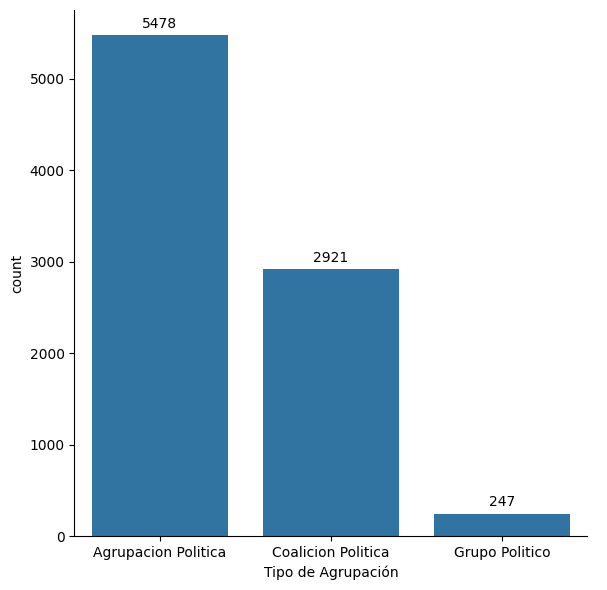

In [5]:
sns.catplot( x="Tipo de Agrupación",kind="count",height=6,aspect=1,data=ingresos_df)
autoLabel()
plt.show()

## Normalizar datos de la columna Codigo Pro

In [6]:
ingresos_df["Codigo Pro"].unique()

array(['101 - Recursos propios y familiares',
       '102 - Donaciones de particulares',
       '106 - Recursos de origen privado destinado por los partidos',
       '107 - Rendimientos\xa0financieros',
       '104 - Ingresos de actos públicos del partido',
       '103 - Créditos de entidades financieras',
       '105 - Financiación estatal - Anticipos'], dtype=object)

In [7]:
def normalizeCodigoPro(fila):
    codigo = fila["Codigo Pro"]
    if isinstance(codigo, str):
        if codigo.startswith("107"):
            return codigo.replace(u'\xa0', u' ')
        else:
         return codigo
    else:
        return codigo


ingresos_df["Codigo Pro"] = ingresos_df.apply(normalizeCodigoPro, axis=1)
ingresos_df["Codigo Pro"].unique()

array(['101 - Recursos propios y familiares',
       '102 - Donaciones de particulares',
       '106 - Recursos de origen privado destinado por los partidos',
       '107 - Rendimientos financieros',
       '104 - Ingresos de actos públicos del partido',
       '103 - Créditos de entidades financieras',
       '105 - Financiación estatal - Anticipos'], dtype=object)

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_6440\1905762358.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


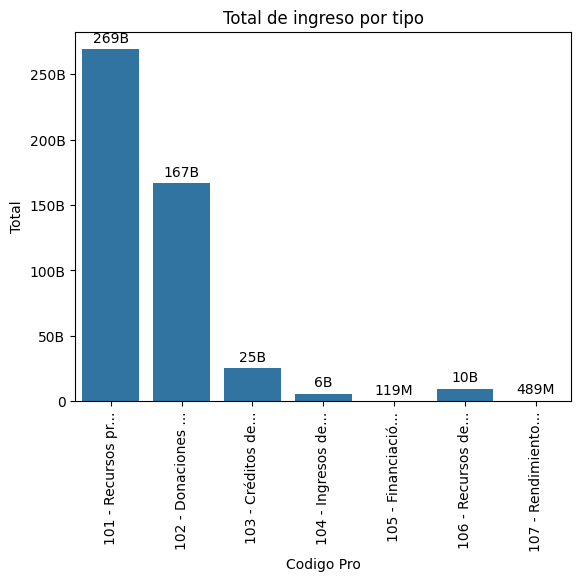

In [17]:
sns.barplot(
    x="Codigo Pro",
    y="Total",
    data=ingresos_df.groupby("Codigo Pro")["Total"].sum().reset_index(),
)
plt.title("Total de ingreso por tipo")
plt.xticks(rotation=90)

def truncate_label(label, length=20):
    if len(label) > length:
        return label[: length - 3] + "..."
    else:
        return label


format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]


    
formatter = FuncFormatter(millions_billions_formatter)
plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(formatter)
autoLabel()
plt.show()

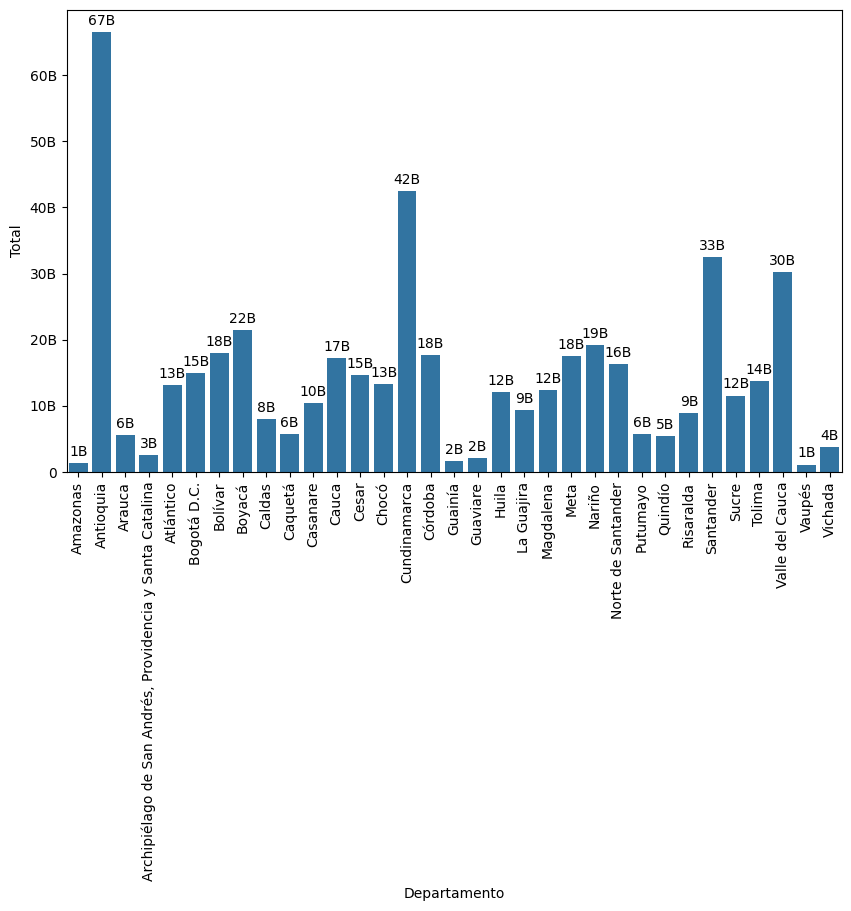

In [9]:
plt.figure(figsize=(10, 6)) 
sns.barplot(
    x="Departamento",
    y="Total",
    data=ingresos_df.groupby("Departamento")["Total"].sum().reset_index(),
)
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(formatter)
autoLabel()

plt.show()

In [10]:
len(ingresos_df['Nombre de Agrupación'].unique())

1840

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


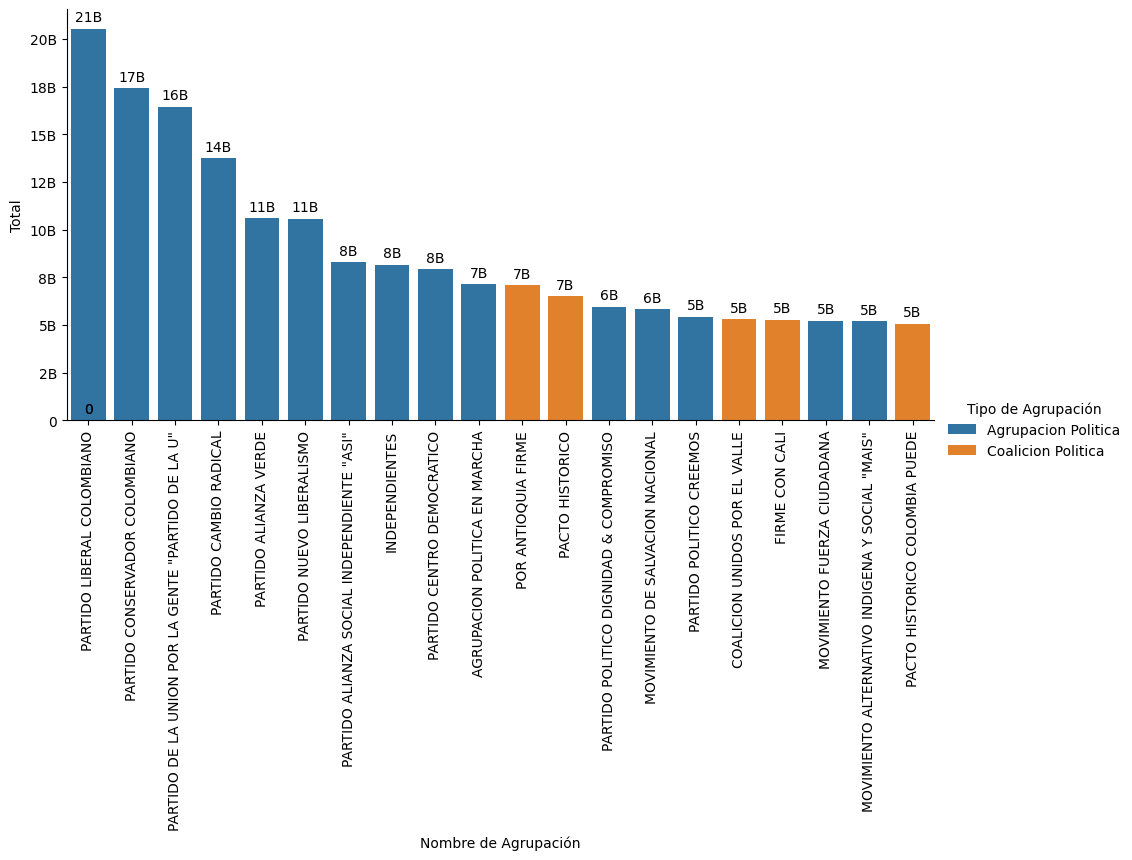

In [11]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
df_suma_total = ingresos_df.groupby(['Nombre de Agrupación', 'Tipo de Agrupación'])['Total'].sum().reset_index()

# Filtrar los primeros 10 resultados
df_top_10 = df_suma_total.nlargest(20, 'Total')

# Luego, puedes usar seaborn para trazar un catplot
sns.catplot(x="Nombre de Agrupación", y="Total", hue="Tipo de Agrupación", kind="bar", data=df_top_10, aspect=2)

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(formatter)
autoLabel()
plt.show()

In [12]:
def joinNameAndLastname(row):
    return row["Nombre"] + " " + row["Apellido"]

ingresos_df["Nombre"] = ingresos_df.apply(joinNameAndLastname, axis=1)
ingresos_df.drop(columns=["Apellido"])
ingresos_df.head()

,Nombre,Apellido,Cargo,Gasto Id,Sexo,Etnia,Departamento,Ciudades,Total,Contar,Etnias,Género,Codigo Pro,Formato Ingresos Gastos - ID Formato Ingresos Gasto → Nombre,Tipos Circunscripcion - ID Circunscripcion → Nombre,Tipo de Agrupación,Nombre de Agrupación
0,ABAD DE JESUS MARIN ARCILA,MARIN ARCILA,Alcaldia_fun,101,M,NaN,Antioquia,San Rafael,29000000.0,3,NaN,Masculino,101 - Recursos propios y familiares,NaN,NaN,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
1,ABAD DE JESUS MARIN ARCILA,MARIN ARCILA,Alcaldia_fun,102,M,NaN,Antioquia,San Rafael,100000.0,1,NaN,Masculino,102 - Donaciones de particulares,NaN,NaN,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
2,ABAD DE JESUS MARIN ARCILA,MARIN ARCILA,Alcaldia_fun,106,M,NaN,Antioquia,San Rafael,12000000.0,3,NaN,Masculino,106 - Recursos de origen privado destinado por...,NaN,NaN,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
3,ABEL ALBERTO POLANCO LEMOS,POLANCO LEMOS,Alcaldia_fun,101,M,NaN,Bolívar,Tiquisio,25000000.0,1,NaN,Masculino,101 - Recursos propios y familiares,NaN,NaN,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO
4,ABEL ANGEL QUIÑONES URBANO,QUIÑONES URBANO,Alcaldia_fun,101,M,1.0,Nariño,Ricaurte,9500000.0,1,Indígenas,Masculino,101 - Recursos propios y familiares,NaN,NaN,Agrupacion Politica,"MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA ""..."


c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


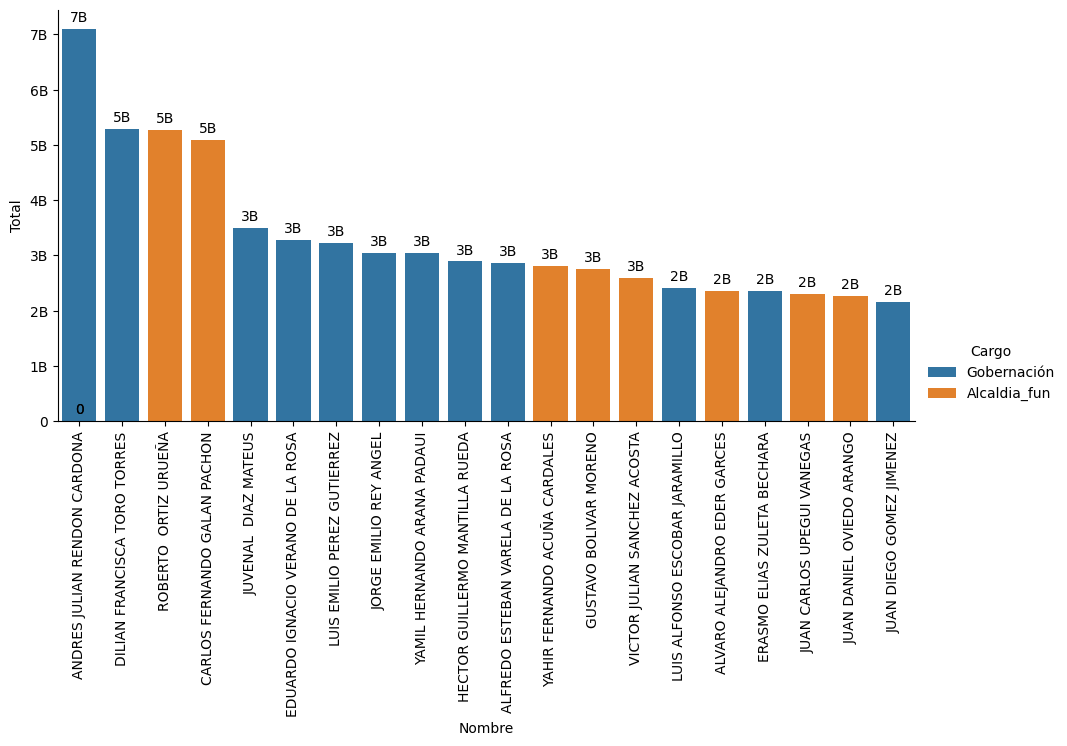

In [13]:
# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
df_suma_total = ingresos_df.groupby(['Nombre', 'Cargo'])['Total'].sum().reset_index()

# Filtrar los primeros 10 resultados
df_top_10 = df_suma_total.nlargest(20, 'Total')

# Luego, puedes usar seaborn para trazar un catplot
sns.catplot(x="Nombre", y="Total", hue="Cargo", kind="bar", data=df_top_10, aspect=2)

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(formatter)
autoLabel()
plt.show()

In [14]:
ingresos_df["Departamento"].unique()

array(['Antioquia', 'Bolívar', 'Nariño', 'Atlántico', 'Putumayo',
       'Caldas', 'Magdalena', 'Santander', 'Córdoba', 'Huila', 'Tolima',
       'Meta', 'Chocó', 'Valle del Cauca', 'Cundinamarca', 'Boyacá',
       'Cesar', 'Sucre', 'Cauca', 'Norte de Santander', 'Vichada',
       'Casanare', 'La Guajira', 'Risaralda',
       'Archipiélago de San Andrés, Providencia y Santa Catalina',
       'Quindío', 'Caquetá', 'Arauca', 'Amazonas', 'Guainía',
       'Bogotá D.C.', 'Vaupés', 'Guaviare'], dtype=object)

In [15]:
ingresos_df["Cargo"].unique()

array(['Alcaldia_fun', 'Gobernación'], dtype=object)

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


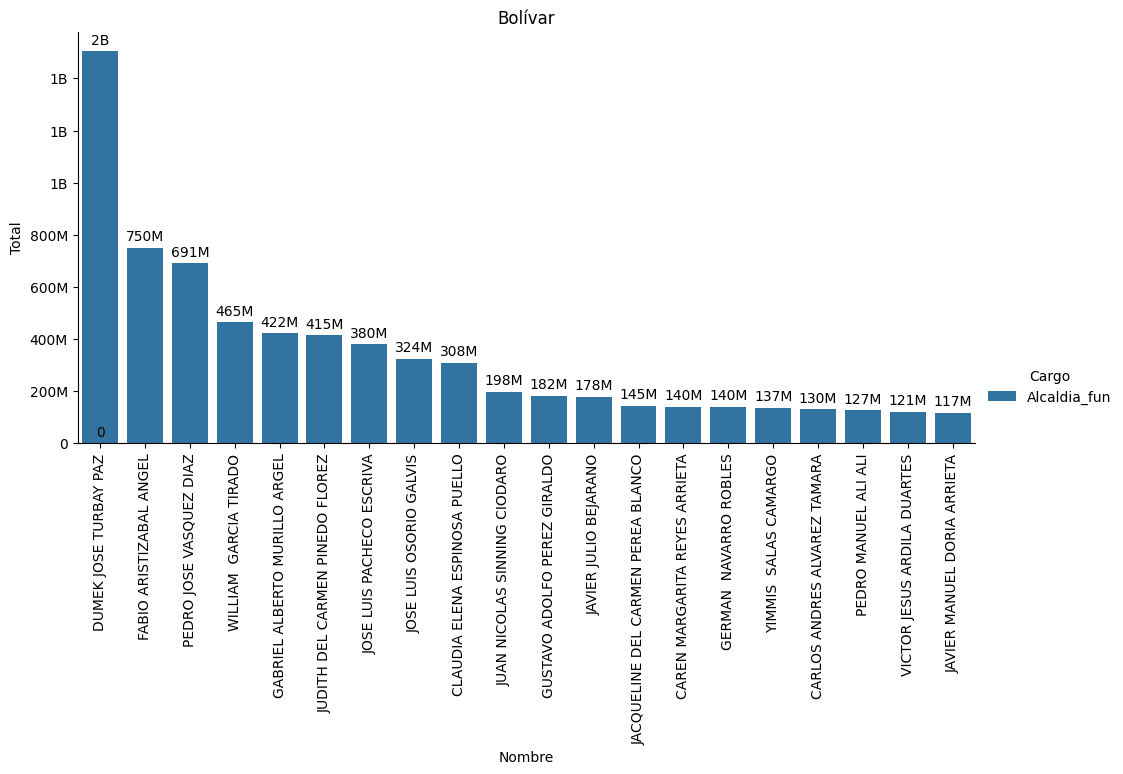

In [16]:
# Luego, puedes usar seaborn para trazar un catplot
departamento = "Bolívar"
cargo="Alcaldia_fun"
gastos_departamento_df = ingresos_df[(ingresos_df["Departamento"] == departamento)&(ingresos_df["Cargo"]==cargo)]

# Calcular la suma del Total por Nombre de Agrupación y Tipo de Agrupación
df_suma_total = gastos_departamento_df.groupby(["Nombre", "Cargo"])["Total"].sum().reset_index()

# Filtrar los primeros 10 resultados
df_top_10 = df_suma_total.nlargest(20, "Total")


sns.catplot(
    x="Nombre",
    y="Total",
    hue="Cargo",
    kind="bar",
    data=df_top_10,
    aspect=2,
)
plt.title(departamento)

plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(formatter)
autoLabel()
plt.show()

In [ ]:
ingresos_df["Ciudades"].fillna("Desconocido", inplace=True)

ingresos_df = ingresos_df.pivot_table(
    index=[
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Contar",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    columns="Codigo Pro",
    values="Total",
    aggfunc="sum",
    # dropna=False,
    # fill_value=0,
)

ingresos_df = ingresos_df.reset_index()

ingresos_df.columns.name = None

ingresos_df = ingresos_df.groupby(
    [
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    as_index=False,
).agg(
    {
        "Contar": "sum",
        "101 - Recursos propios y familiares": "sum",
        "102 - Donaciones de particulares": "sum",
        "106 - Recursos de origen privado destinado por los partidos": "sum",
        "107 - Rendimientos financieros": "sum",
        "104 - Ingresos de actos públicos del partido": "sum",
        "103 - Créditos de entidades financieras": "sum",
        "105 - Financiación estatal - Anticipos": "sum",
    }
)
ingresos_df.shape